# **CHESCA SIMULATION (CityLearn Challenge 2023 Winner)**

---

**Import list**

In [ ]:
# Force the correct environment for CityLearn
!pip uninstall -y numpy tensorboard tensorflow
!pip install numpy==1.23.5
!pip install tensorflow==2.12.0
!pip install tensorboard==2.12.3
!pip install citylearn

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: tensorboard 2.12.3
Uninstalling tensorboard-2.12.3:
  Successfully uninstalled tensorboard-2.12.3
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, which is not installed.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requ

  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached tensorboard-2.12.3-py3-none-any.whl.metadata (1.8 kB)
Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (586.0 MB)
Using cached tensorboard-2.12.3-py3-none-any.whl (5.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.12.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
  Using cached CityLearn-2.3.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached doe_xstock-1.1.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached nrel_p

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/src')

from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import *
from agents.checa.agent import Checa as Agent

# Reward import
from rewards.CityLearnReward import SolarPenaltyAndComfortReward
from rewards.ComfortandConsumptionReductionReward import ComfortandConsumptionReductionReward

# Data structure import
import pandas as pd
from datetime import datetime

# Plot import
from utils import plotting_functions as plt
from IPython.display import display, Markdown

# Warning hider
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/src
# The previous command is necessary for loading correctly all file

import os
print(os.path.exists('agents/checa/forecast_agent/pretrained/xgboost_outdoor_temp_0_1.json'))


# Initialitation
train_env = CityLearnEnv('citylearn_challenge_2023_phase_2_local_evaluation', central_agent=True)
eval_env = CityLearnEnv('citylearn_challenge_2023_phase_2_online_evaluation_3', central_agent=True)
rf = SolarPenaltyAndComfortReward(train_env.schema)
eval_env.reward_function = rf
train_env.reward_function = rf

train_env.random_seed=0
eval_env.random_seed=0

# Agent
model = Agent(train_env)

# Number of the chosen building and number of episode trainig
num_building = 0
num_episodes = 1

# Reset
observations, _ = train_env.reset()

# Training
model.learn(episodes=num_episodes, deterministic_finish=False)
display(Markdown("Training Data Result"))
df = plt.create_episode_table(train_env.episode_rewards)
display(df)

# Evaluate
observations, _ = eval_env.reset()
while not eval_env.terminated:
    actions = model.predict(observations, deterministic=True)
    observations, _, _, _, _ = eval_env.step(actions)

env = eval_env

/content/drive/MyDrive/Colab Notebooks/src
True


Training Data Result

,Episodio,Reward Min,Reward Max,Reward Somma,Reward Media
0,1,-67.705101,0.0,-8688.697266,-12.084419


The learn() function runs multiple episodes on the environment, training the agent. The very last episode is executed manually in deterministic_finish mode. In this final phase, the agent uses only the learned policy to select actions, without any further updates or exploration.


----

## **Cost Function and building parameter**


In [ ]:
kpis_names = {
    'electricity_consumption_total': 'Total grid consumption',
    'carbon_emissions_total': 'Emissions',
    'discomfort_proportion': 'Proportion of time outside comfort range',
    'daily_peak_minus_load_factor_average': 'Measure of inefficiency in daily power usage',
    'daily_peak_average': 'Average daily peak',
    'all_time_peak_average': 'Maximum district consumption peak',
    'one_minus_thermal_resilience_proportion': 'Discomfort proportion during power outages',
    'power_outage_normalized_unserved_energy_total': 'Unmet demand due to energy shortage',
    'ramping_average': 'Average difference between current and previous timestep consumption',
    # Here to add cost function
}


display(Markdown(f"### **CHESCA - Base Version**"))
display(Markdown("----"))

kpis = env.evaluate()
kpis = kpis[(kpis['cost_function'].isin(kpis_names))].dropna()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
display(kpis)

### **CHESCA - Base Version**

----

name,Building_1,Building_2,Building_3,District
cost_function,,,,
all_time_peak_average,NaN,NaN,NaN,0.903
carbon_emissions_total,0.828,1.084,0.949,0.953
daily_peak_average,NaN,NaN,NaN,0.855
discomfort_proportion,0.024,0.015,0.001,0.013
electricity_consumption_total,0.833,1.087,0.953,0.957
one_minus_thermal_resilience_proportion,0.154,0.308,0.083,0.182
power_outage_normalized_unserved_energy_total,0.262,0.222,0.218,0.234
ramping_average,NaN,NaN,NaN,0.801



------

## **Consumption Behavior**

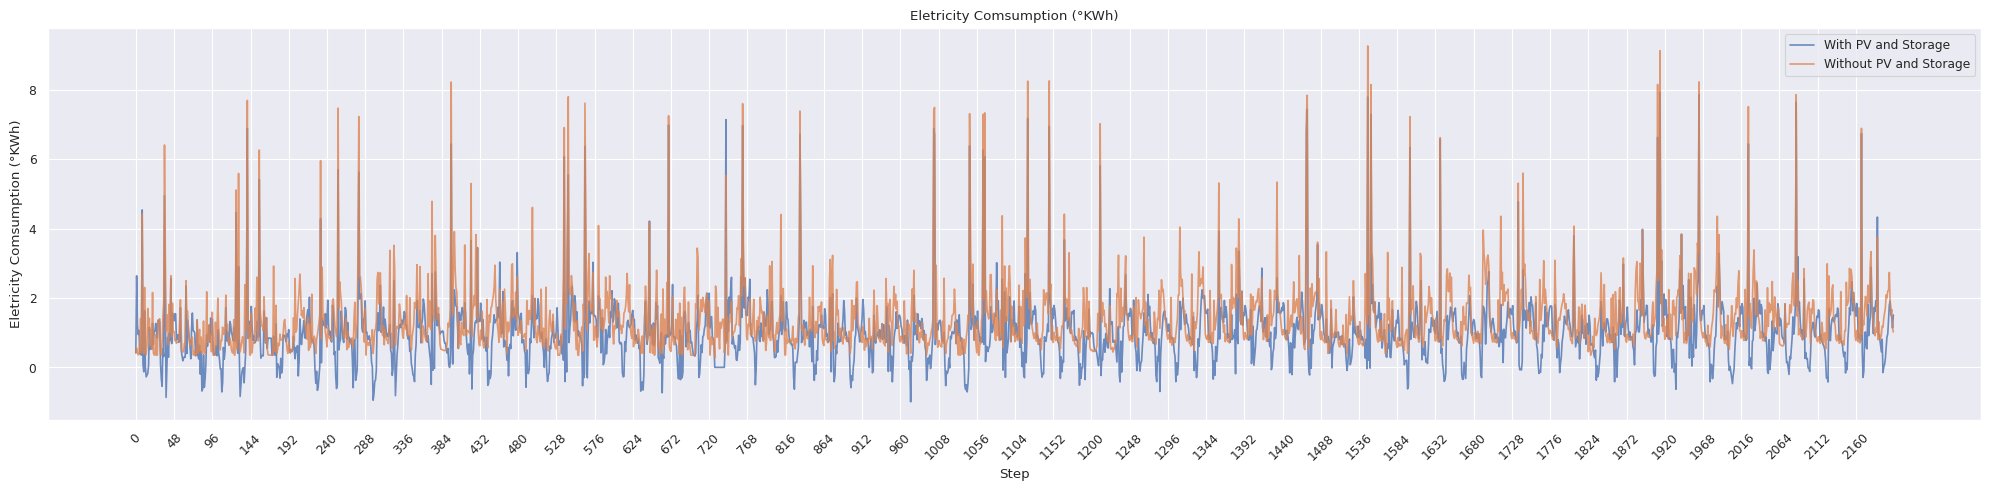

In [ ]:
energy_with_pv= env.unwrapped.buildings[num_building].net_electricity_consumption
energy_without_pv = env.unwrapped.buildings[num_building].net_electricity_consumption_without_storage_and_pv

plt.plot_comparison_two(
    energy_with_pv,
    energy_without_pv,
    ylabel='Eletricity Comsumption (°KWh)',
    title='Eletricity Comsumption (°KWh)',
    label1='With PV and Storage',
    label2='Without PV and Storage'
)

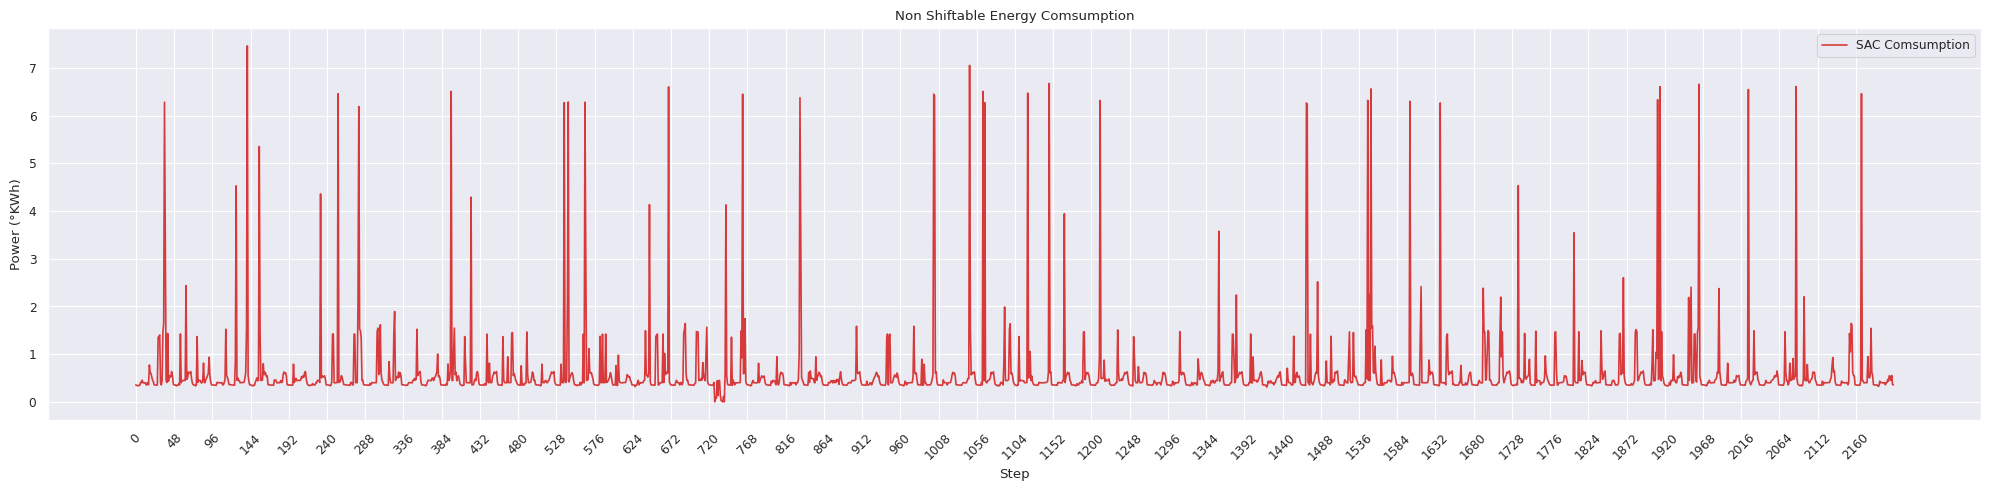

In [ ]:
non_energy = env.unwrapped.buildings[num_building].non_shiftable_load_electricity_consumption

plt.plot_single_agent(
    non_energy,
    ylabel='Power (°KWh)',
    title='Non Shiftable Energy Comsumption',
    label='CHESCA Comsumption',

)


------

## **Temperature behavior**

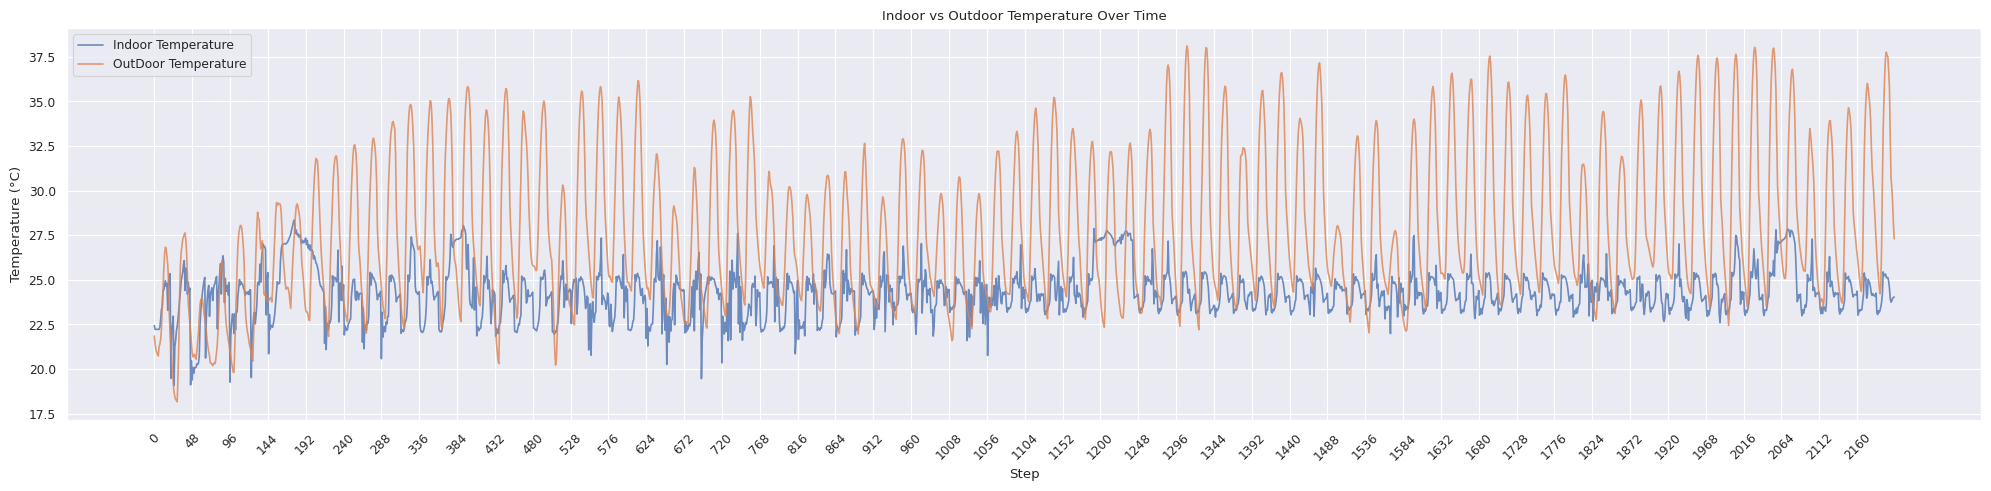

In [ ]:
indoor_base_temp = env.unwrapped.buildings[num_building].indoor_dry_bulb_temperature
outdoor_temp = env.unwrapped.buildings[num_building].weather.outdoor_dry_bulb_temperature

plt.plot_comparison_two(
    indoor_base_temp,
    outdoor_temp,
    ylabel='Temperature (°C)',
    title='Indoor vs Outdoor Temperature Over Time',
    label1='Indoor Temperature',
    label2='OutDoor Temperature'
)

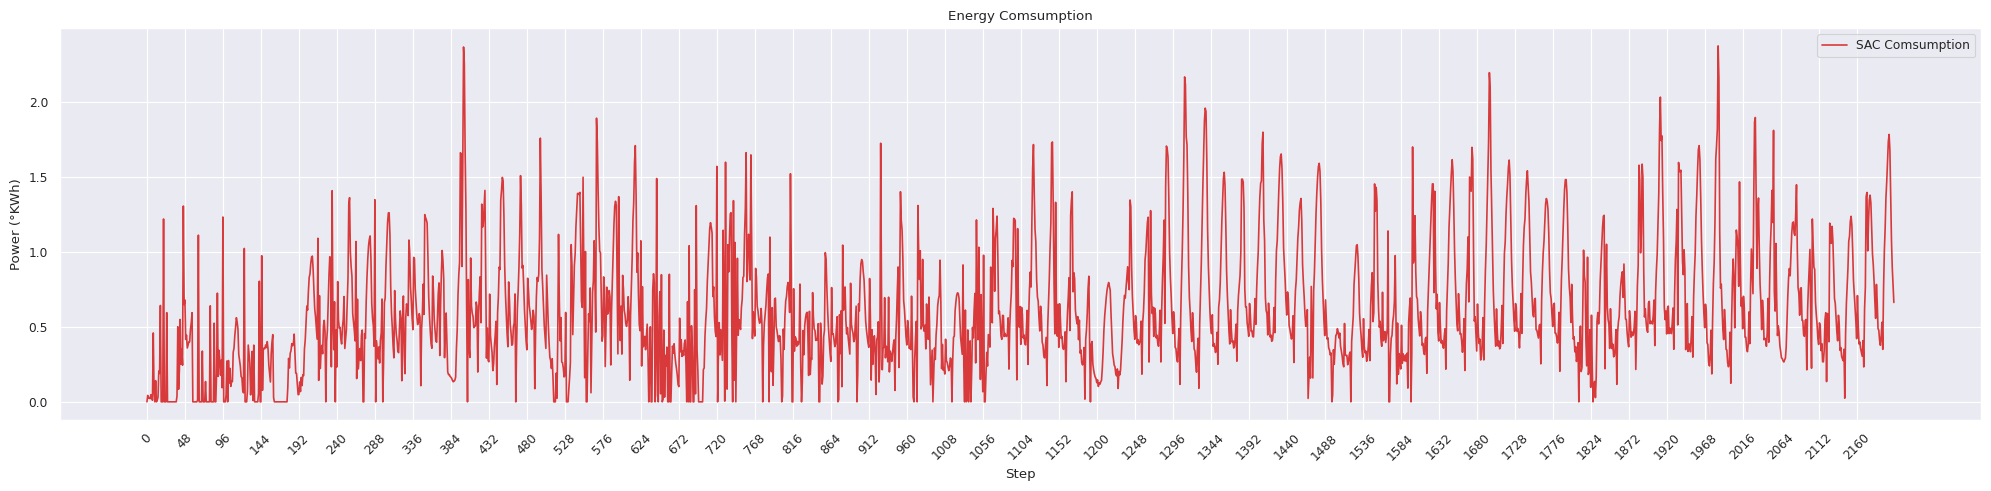

In [ ]:
cooler_energy = env.unwrapped.buildings[num_building].cooling_electricity_consumption

plt.plot_single_agent(
    cooler_energy,
    ylabel='Power (°KWh)',
    title='Cooling Energy Comsumption',
    label='CHESCA Comsumption',
)


----

## **Batteries and accumulators behavior**

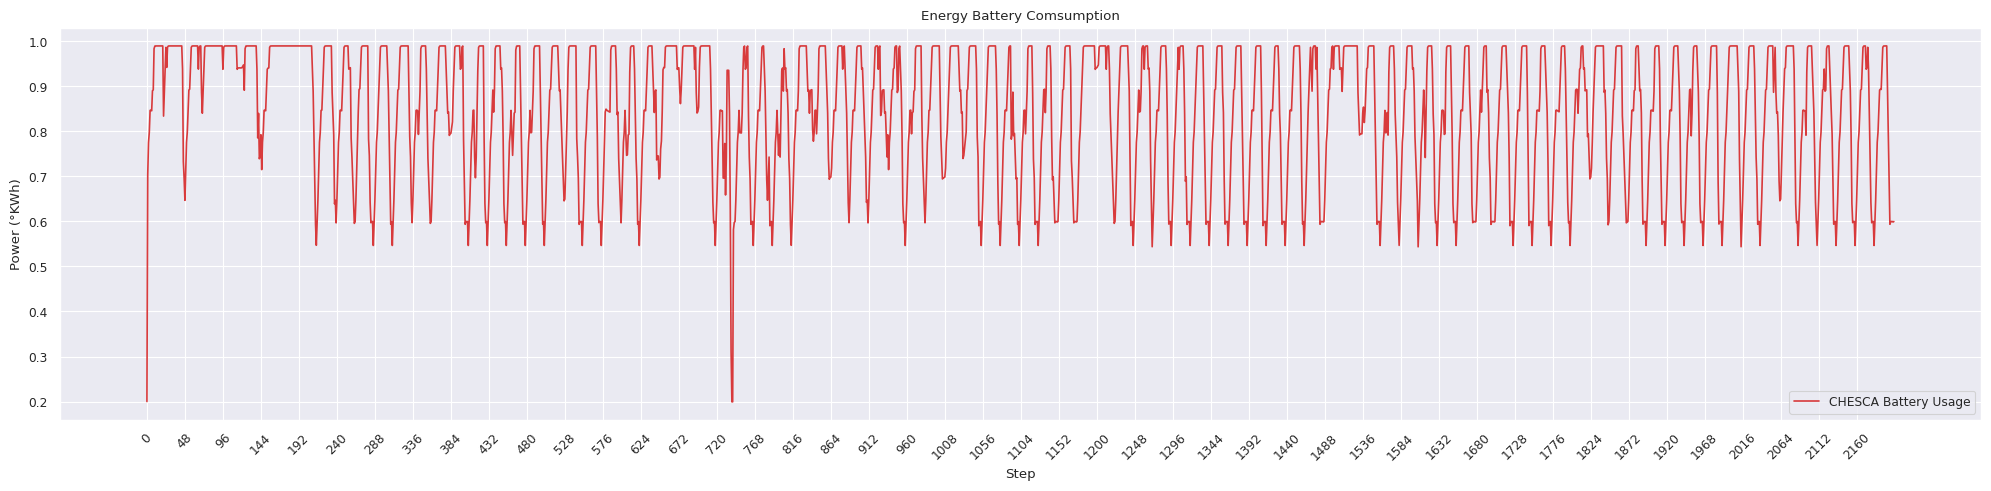

In [ ]:
agent_data1 = env.unwrapped.buildings[num_building].electrical_storage.soc

plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='Energy Battery Comsumption',
    label='CHESCA Battery Usage',
)

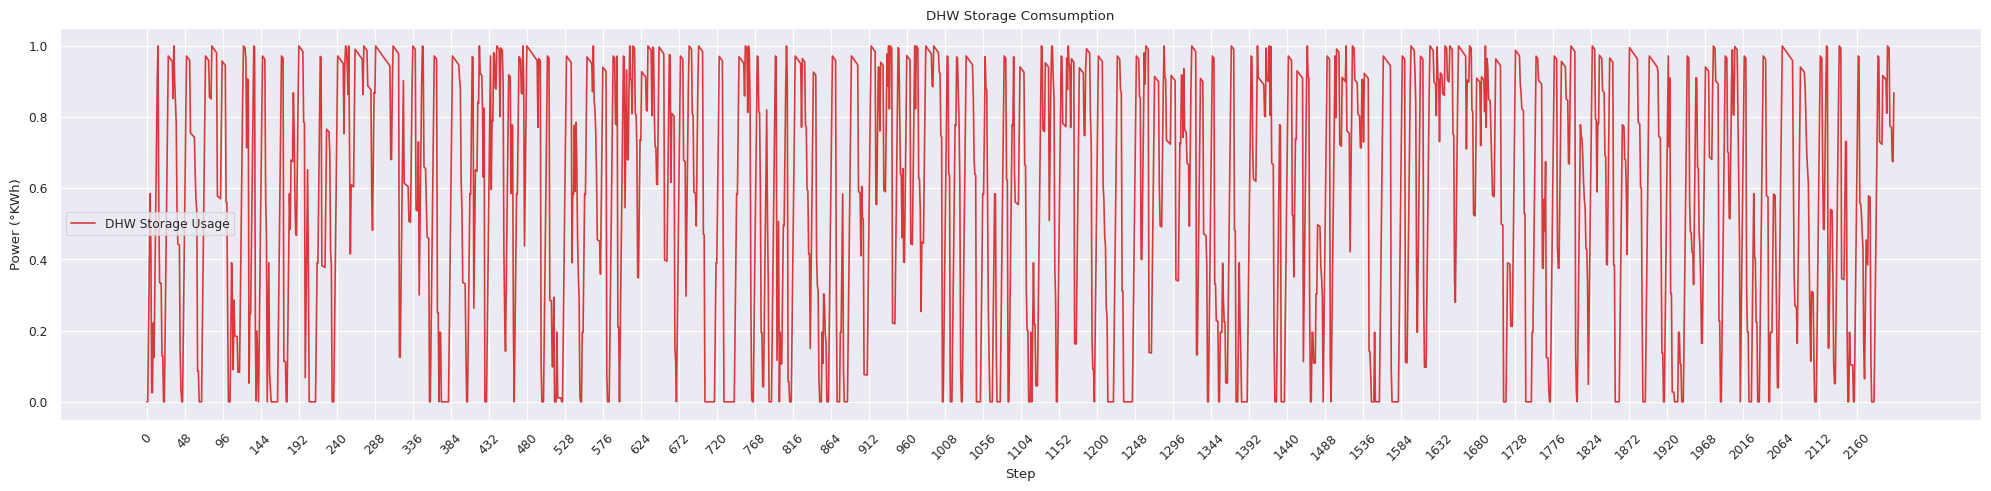

In [ ]:
agent_data1 = env.unwrapped.buildings[num_building].dhw_storage.soc

plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='DHW Storage Comsumption',
    label='DHW Storage Usage'
)


----

## **Emissions behavior**


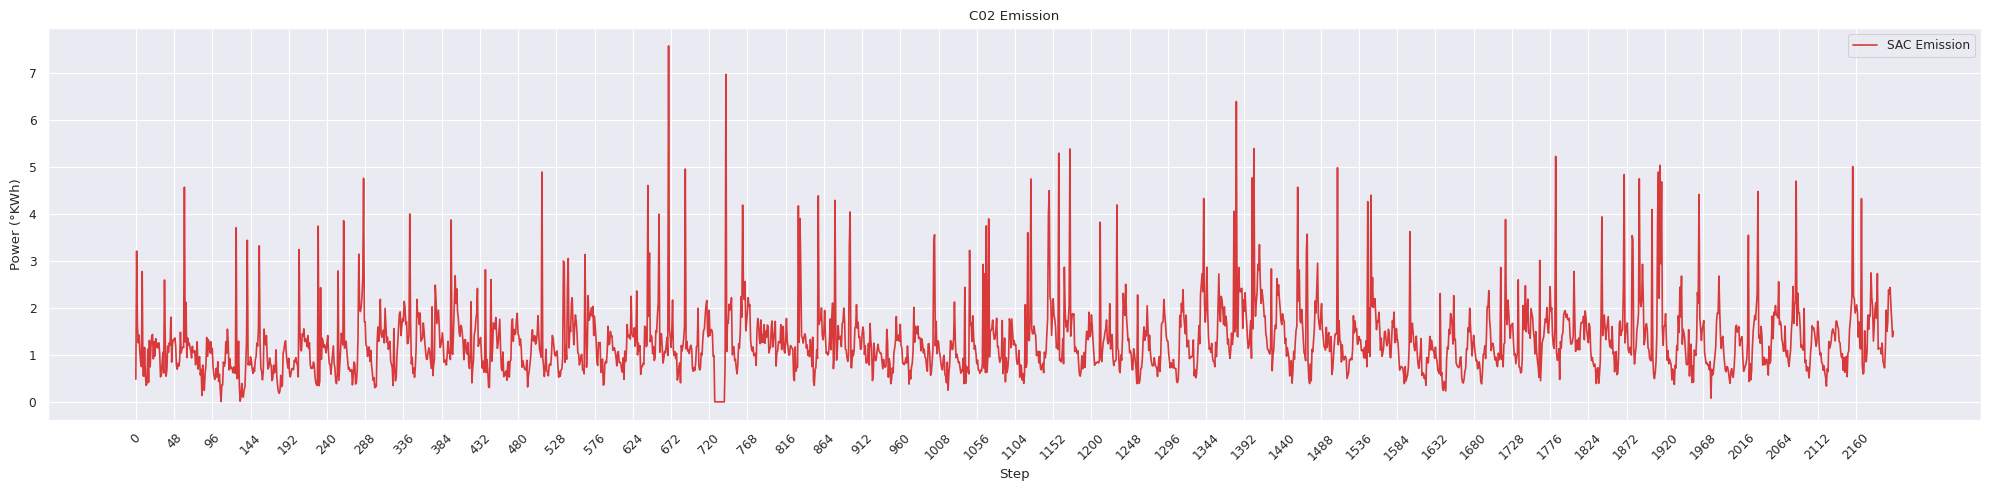

In [ ]:
agent_data1 = env.unwrapped.net_electricity_consumption_emission

plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='C02 Emission',
    label='CHESCA Emission'
)


----

## **Learning metrics**

### **SAC - Base Version**

----

,Episodio,Reward Min,Reward Max,Reward Somma,Reward Media
0,1,-60.691811,0.0,-24227.0625,-10.977373


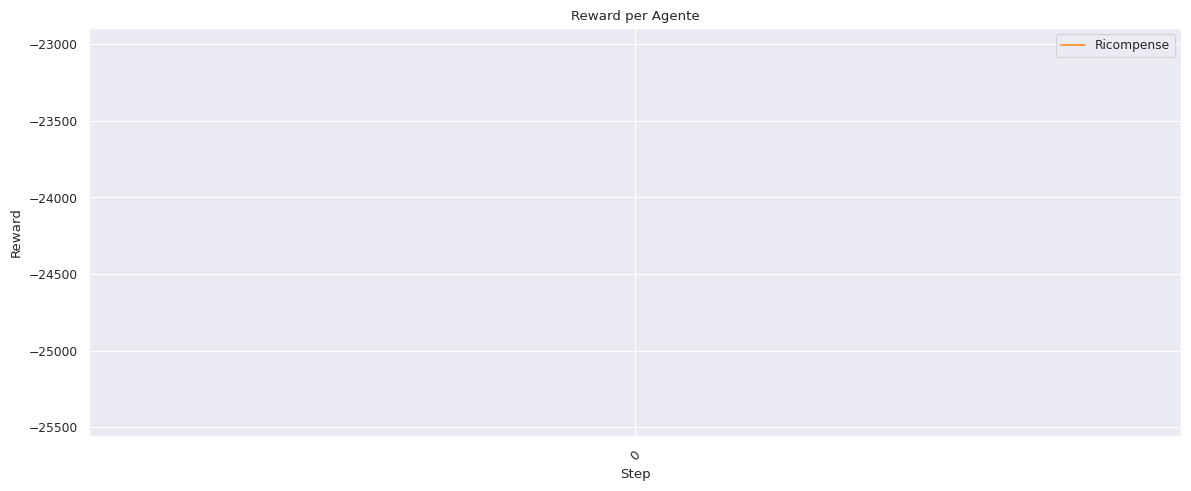

In [ ]:
df = plt.create_episode_table(env.unwrapped.episode_rewards)

display(Markdown(f"### **CHESCA - Base Version**"))
display(Markdown("----"))
display(df)

plt.plot_rewards(df['Reward Sum'])